In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [ transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2
                                         )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False, 
                                         num_workers=2
                                        )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 27123227.82it/s]                               


Files already downloaded and verified


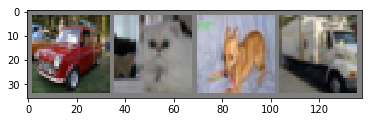

  car   cat   dog truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
# input = torch.randn(2,3,2,2) * 4 + 3
# mean = torch.mean(input, dim=(0,2,3))
# print(mean[None, :, None, None])
# input = input - mean[None, :, None, None]
# print(input)

# **Batch normalization algorithm**

**Input**: Values of $x$ over a mini-batch: $\beta = \left \{ x_{1..m} \right \};$ 

Parameters to be learned: $\gamma, \beta$

**Output**:  $ \left \{ y_{i} = \mathrm{BN_{\gamma,\beta}}(x_i)  \right \} $ 

$\mu_{B} \leftarrow  \frac{1}{m}\sum_{i=1}^{m}x_{i}$    //mini batch mean
 
 $\sigma_{B}^{2} \leftarrow \frac{1}{m}\sum_{i=1}^{m} (x_{i} - \mu_{B})^{2}$    //mini-batch variance 
 
 $\widehat{x}_{i} \leftarrow \frac{x_{i} - \mu_{B}}{\sqrt{\sigma_{B}^{2} + \epsilon}}$    //normalize 
 
 $y_{i} \leftarrow \gamma \widehat{x}_{i} + \beta \equiv \mathrm{BN_{\gamma,\beta}}(x_i)$     //scale and shift 
 
 Now at training time we calculate mean and variance for each mini-batch. But in inference time we do not calculate mean and variance for test data. Rather we calculate population average of mean and variances after training, using all the mini-batch mean and variances. Then at evaluation, we fix the mean and variance to this value. 
 
 $\mathbb{E}[x] \leftarrow \mathbb{E}_{B}[\mu_{B}]$
 
 $Var[x] \leftarrow \frac{m}{m-1} \mathbb{E}_{B}[\sigma_{B}^{2}]$
 
 But it is difficult to keep track of all the mini-batch mean and variances. So, that's why, exponential weighted *moving average* is used to update population mean and variance
 
 $\mu_{mov} = \alpha * \mu_{mov} + (1-\alpha)*\mu_{B}$
 
 $\sigma^{2}_{mov} = \alpha * \sigma_{mov}^{2} + (1-\alpha)*\sigma_{B}^{2}$
 


> Done in Line $22$ and $24$


 
 Here $\alpha$ is the momentum and the ones with $B$ subscript are mini-batch mean and variance.
 
 Also a note that the *moving mean and variance* are calculated at training time but not at evaluation. That's why the whole calculation is in "if" block of "self.training" at line $12$.

In [0]:
# Batch Normalization 
class MyBatchNorm2d(nn.BatchNorm2d):
  def __init__(self, num_features, eps = 1e-5, momentum=0.1, affine=True, track_running_stats=True):
    super(MyBatchNorm2d, self).__init__(num_features, eps = 1e-5, momentum=0.1, affine=True, track_running_stats=True)
  
  def forward(self, x):
    self._check_input_dim(x) 
    
    momentum = self.momentum
    
#     for training
    if self.training:
    # (batch_size, no_of_channel, row, column). We want to take mean and variance over 3 channels. The normalization is done along channel axis.
#     Why? Hint: Weight Sharing
      mean = torch.mean(x, dim=(0, 2, 3))
      var = torch.var(x, dim=(0, 2, 3), unbiased=False) # biased variance is used in training.
      m = x.numel() / x.size(1)  # no of elements(batch_size * channel_no * row * column) / channel no = no of elements of each channel per batch
      
#     According to batchnorm paper, Take population average for running mean and variance
#     and take an exponential weighted moving average of those two.
      with torch.no_grad():
        self.running_mean = momentum * mean + (1 - momentum) * self.running_mean
        
        self.running_var = momentum * var * m / (m-1) + (1 - momentum) * self.running_var

    #   for evaluation
    else:
      mean = self.running_mean # for evaluation use the running_mean that was used in training
      var = self.running_var # same
      
#     Normalization eqn, x = (x - mu) / sqrt(var + epsilon)  
    x = ( x - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))  
    
#     affine is used to update the parameter (gamma, beta). So weight = gamma and bias = beta.
#   The equation of BatchNorm for output, y = gamma * x + Beta 
    if self.affine:
      x = x * self.weight[None,:,None,None] + self.bias[None,:,None,None]
    
    return x 

In [6]:
# check if BatchNorm works compared with BatchNorm of pytorch.
x = torch.randn(2,3,4,4) * 8 + 3
my_bn = MyBatchNorm2d(3, affine=True)
torch_bn = nn.BatchNorm2d(3, affine=True)
out1 = my_bn(x)
out2 = torch_bn(x)
print('Max diff: ', (out1 - out2).abs().max().item())

Max diff:  0.7433098554611206


In [7]:
class ModelWithMyBatchNorm(nn.Module):
    def __init__(self):
        super(ModelWithMyBatchNorm, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = MyBatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = MyBatchNorm2d(16)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1((self.conv1(x)))))
        x = self.pool(F.relu(self.bn2((self.conv2(x)))))
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ModelWithMyBatchNorm()
print(model)

ModelWithMyBatchNorm(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): MyBatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): MyBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

ModelWithMyBatchNorm(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): MyBatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): MyBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
EPOCHS = 5
print_every = 2000

for epoch in range(EPOCHS):
  
  running_loss = 0.0
  
  for iters, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device) 
    
#     make gradients parameter zero
    optimizer.zero_grad()
    
#     forward propagation
    outputs = model(inputs)
#   calculate loss
    loss = criterion(outputs, labels)
#   do backward propagation
    loss.backward()
#   update weights
    optimizer.step()
    
#     print result
    running_loss += loss.item()
    if iters % print_every == 1999:
      print("epoch: %d, iterations: %5d, loss: %.3f" % 
           (epoch + 1, iters + 1, running_loss / print_every))
      
      running_loss = 0.0
      
print("Finished Training")

epoch: 1, iterations:  2000, loss: 1.875
epoch: 1, iterations:  4000, loss: 1.666
epoch: 1, iterations:  6000, loss: 1.587
epoch: 1, iterations:  8000, loss: 1.526
epoch: 1, iterations: 10000, loss: 1.477
epoch: 1, iterations: 12000, loss: 1.432
epoch: 2, iterations:  2000, loss: 1.381
epoch: 2, iterations:  4000, loss: 1.349
epoch: 2, iterations:  6000, loss: 1.320
epoch: 2, iterations:  8000, loss: 1.302
epoch: 2, iterations: 10000, loss: 1.320
epoch: 2, iterations: 12000, loss: 1.274
epoch: 3, iterations:  2000, loss: 1.201
epoch: 3, iterations:  4000, loss: 1.227
epoch: 3, iterations:  6000, loss: 1.220
epoch: 3, iterations:  8000, loss: 1.192
epoch: 3, iterations: 10000, loss: 1.188
epoch: 3, iterations: 12000, loss: 1.194
epoch: 4, iterations:  2000, loss: 1.152
epoch: 4, iterations:  4000, loss: 1.132
epoch: 4, iterations:  6000, loss: 1.133
epoch: 4, iterations:  8000, loss: 1.106
epoch: 4, iterations: 10000, loss: 1.139
epoch: 4, iterations: 12000, loss: 1.106
epoch: 5, iterat

Let's implement without batch normalization

In [11]:
class ModelWithBatchNorm(nn.Module):
    def __init__(self):
        super(ModelWithBatchNorm, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1((self.conv1(x)))))
        x = self.pool(F.relu(self.bn2((self.conv2(x)))))
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model2 = ModelWithBatchNorm()
print(model2)
model2.to(device)

ModelWithBatchNorm(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


ModelWithBatchNorm(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [13]:
for epoch in range(EPOCHS):
  
  running_loss = 0.0
  
  for iters, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device) 
    
#     make gradients parameter zero
    optimizer2.zero_grad()
    
#     forward propagation
    outputs = model2(inputs)
#   calculate loss
    loss = criterion(outputs, labels)
#   do backward propagation
    loss.backward()
#   update weights
    optimizer2.step()
    
#     print result
    running_loss += loss.item()
    if iters % print_every == 1999:
      print("epoch: %d, iterations: %5d, loss: %.3f" % 
           (epoch + 1, iters + 1, running_loss / print_every))
      
      running_loss = 0.0
      
print("Finished Training")

epoch: 1, iterations:  2000, loss: 1.891
epoch: 1, iterations:  4000, loss: 1.660
epoch: 1, iterations:  6000, loss: 1.554
epoch: 1, iterations:  8000, loss: 1.509
epoch: 1, iterations: 10000, loss: 1.452
epoch: 1, iterations: 12000, loss: 1.428
epoch: 2, iterations:  2000, loss: 1.359
epoch: 2, iterations:  4000, loss: 1.357
epoch: 2, iterations:  6000, loss: 1.318
epoch: 2, iterations:  8000, loss: 1.330
epoch: 2, iterations: 10000, loss: 1.293
epoch: 2, iterations: 12000, loss: 1.296
epoch: 3, iterations:  2000, loss: 1.219
epoch: 3, iterations:  4000, loss: 1.243
epoch: 3, iterations:  6000, loss: 1.231
epoch: 3, iterations:  8000, loss: 1.205
epoch: 3, iterations: 10000, loss: 1.212
epoch: 3, iterations: 12000, loss: 1.222
epoch: 4, iterations:  2000, loss: 1.167
epoch: 4, iterations:  4000, loss: 1.184
epoch: 4, iterations:  6000, loss: 1.151
epoch: 4, iterations:  8000, loss: 1.150
epoch: 4, iterations: 10000, loss: 1.149
epoch: 4, iterations: 12000, loss: 1.133
epoch: 5, iterat

In [17]:
correct1, correct2 = 0, 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    output1 = model(images)
    output2 = model2(images)
    
    _, predicted = torch.max(output1.data, 1)
    _, predicted2 = torch.max(output2.data, 1)
    
    total += labels.size(0)
    
    correct1 += (predicted == labels).sum().item()
    correct2 += (predicted2 == labels).sum().item()
    
print("Accuracy of the network using my batch norm: %2.3f %%" % (100 * correct1 / total))
print("Accuracy of the network using pytorch's built-in batch norm: %2.3f %%" % (100 * correct2 / total))
print("Diff: %.3f" % ((100 * correct1 / total) - (100 * correct2 / total)))

Accuracy of the network using my batch norm: 59.060 %
Accuracy of the network using pytorch's built-in batch norm: 59.500 %
Diff: -0.440
